# Quantum State Tomography: Benchmarking Machine Learning (SVR) vs. Maximum Likelihood Estimation (MLE)

## 1. Project Overview & Objectives
The primary objective of this study is to perform a rigorous, multi-dimensional benchmark comparing **Machine Learning** algorithms—specifically **Support Vector Regression (SVR)**—against the standard statistical method of **Maximum Likelihood Estimation (MLE)** for single-qubit quantum tomography.

While MLE is asymptotically optimal, it is computationally intensive, requiring a convex optimization procedure for every single measured state. Machine Learning offers a paradigm shift: by "learning" the inverse map from measurement statistics to quantum states offline, we aim to achieve comparable physical accuracy with drastically reduced online reconstruction times.

## 2. Methodology: A Multi-Dimensional Analysis
To ensure a fair and robust comparison, we structure our experiment around three independent axes of variation. This allows us to determine not just *if* ML works, but *under which physical conditions* it outperforms or lags behind MLE.

### A. The Physical Dimension (Dataset Properties)
We vary the generation parameters to test robustness:
* **Dataset Size (`n_states`):** We test varying training set sizes (e.g., 100, 1000, 5000) to evaluate the sample efficiency of the SVR.
* **Measurement Noise (`n_shots`):** We vary the number of shots per Pauli observable (e.g., 10 to 5000). Low shot counts simulate high statistical noise, testing the denoising capability of the models.
* **Decoherence (`decoherence_level`):** We introduce varying degrees of mixedness (Bloch vectors with norm < 1). This is crucial to verify if the models can correctly reconstruct impure states generated by environmental noise.

### B. The Algorithmic Dimension (SVR Configuration)
We do not treat SVR as a "black box". For each physical configuration, we optimize the model using a Grid Search over specific Kernels and Hyperparameters:

#### **Kernels (The "Shape" of the Solution)**
* **RBF (Radial Basis Function):** The default choice; efficient for non-linear data with localized clusters. It maps inputs to an infinite-dimensional space.
* **Polynomial (`poly`):** Models interactions between features (e.g., $X \cdot Y$). Useful if the physical relationship involves products of measurements.
* **Sigmoid:** Mimics neural network activation functions (hyperbolic tangent). Useful for specific non-linearities but often harder to tune.

#### **Hyperparameters (The "Tuning" Knobs)**
* **$C$ (Regularization):** Controls the trade-off between a smooth decision boundary and classifying training points correctly. High $C$ aims for low training error (risk of overfitting); low $C$ enforces a smoother margin (better generalization).
* **$\gamma$ (Kernel Coefficient):** Defines the "influence" of a single training example. High $\gamma$ means close points have high influence (complex, wiggly model); low $\gamma$ means a broader influence (smoother model).
* **$\epsilon$ (Epsilon-Tube):** Specific to Regression. It defines a margin of tolerance where no penalty is given to errors. Larger $\epsilon$ allows for more "slop" in the prediction, ignoring small noise variations.

## 3. Evaluation Metrics & Justification
We employ three specific metrics to arbitrate the performance, each serving a distinct scientific purpose:

### I. Fidelity ($F$) - The Physical Standard
* **Definition:** $F(\rho, \sigma) = \left( \text{Tr}\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}} \right)^2$. For a single qubit, this quantifies the overlap between the reconstructed state and the true state.
* **Why we use it:** This is the "Gold Standard" in Quantum Information. A low MSE does not strictly guarantee a valid quantum state. Fidelity tells us how physically indistinguishable our reconstruction is from reality.

### II. Computational Cost (Time) - The Efficiency Argument
* **Definition:** We explicitly separate **Training Time** ($t_{fit}$) and **Inference Time** ($t_{predict}$).
* **Why we use it:** This is the central hypothesis of the project. We expect MLE to have a high cost for every new state ($t_{MLE} \approx \text{constant high}$). Conversely, SVR should have a high $t_{fit}$ (offline) but a negligible $t_{predict}$ (online). Validating this speed-up factor is critical for real-time tomography applications.

### III. Mean Squared Error (MSE) - The Optimization Target
* **Definition:** Euclidean distance between the predicted Bloch vector and the real Bloch vector.
* **Why we use it:** While less physical than Fidelity, MSE is the actual loss function minimized by the SVR. Monitoring it helps us diagnose underfitting/overfitting during the Grid Search process.

In [40]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Attempt to import the provided local module
# Assuming the file 'saint_dtSet.py' is in a folder named 'gemi' or in the root path.
try:
    from saint_dtSet import generate_qubit_tomography_dataset_base, perform_mle_tomography
except ImportError:
    # Fallback if the file is in the same directory
    try:
        from dataset_build.saint_dtSet import generate_qubit_tomography_dataset_base, perform_mle_tomography
    except ImportError:
        raise ImportError("Please ensure 'saint_dtSet.py' is in the python path.")

# ------------------------------------------------------------------------------
# METRICS DEFINITION
# ------------------------------------------------------------------------------

def bloch_to_density_matrix(x, y, z):
    """
    Converts Bloch vector components to a 2x2 density matrix.
    rho = 1/2 * (I + x*sigma_x + y*sigma_y + z*sigma_z)
    """
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    identity = np.eye(2, dtype=complex)
    
    rho = 0.5 * (identity + x*sigma_x + y*sigma_y + z*sigma_z)
    return rho

def calculate_fidelity(row, pred_cols=('X_pred', 'Y_pred', 'Z_pred'), real_cols=('X_real', 'Y_real', 'Z_real')):
    """
    Calculates the quantum fidelity between the Real state and the Predicted state.
    
    Formula for single qubit using Bloch vectors r_real and r_pred:
    F(rho, sigma) = 0.5 * (1 + r_real.r_pred + sqrt((1 - |r_real|^2)(1 - |r_pred|^2)))
    
    Note: This analytic formula is faster than matrix sqrt operations.
    """
    # Extract vectors
    r_real = np.array([row[c] for c in real_cols])
    r_pred = np.array([row[c] for c in pred_cols])
    
    # Norms squared
    norm2_real = np.dot(r_real, r_real)
    norm2_pred = np.dot(r_pred, r_pred)
    
    # Dot product
    dot_prod = np.dot(r_real, r_pred)
    
    # Safety clip for sqrt (numerical stability)
    val_real = max(0.0, 1.0 - norm2_real)
    val_pred = max(0.0, 1.0 - norm2_pred)
    
    fidelity = 0.5 * (1.0 + dot_prod + np.sqrt(val_real * val_pred))
    
    # Clip fidelity to [0, 1] range to handle float discrepancies
    return min(max(fidelity, 0.0), 1.0)

def evaluate_performance(df_results, title="Evaluation"):
    """
    Computes global metrics (Average Fidelity, MSE) and prints a summary.
    Expects columns: X_real, Y_real, Z_real AND X_pred, Y_pred, Z_pred.
    """
    print(f"--- {title} ---")
    
    # 1. MSE (Mean Squared Error) on Bloch components
    y_true = df_results[['X_real', 'Y_real', 'Z_real']].values
    y_pred = df_results[['X_pred', 'Y_pred', 'Z_pred']].values
    mse = mean_squared_error(y_true, y_pred)
    
    # 2. Fidelity
    # Apply row-wise calculation
    fidelities = df_results.apply(calculate_fidelity, axis=1)
    avg_fidelity = fidelities.mean()
    std_fidelity = fidelities.std()
    
    print(f"MSE (Bloch Vector): {mse:.6f}")
    print(f"Average Fidelity:   {avg_fidelity:.6f} (+/- {std_fidelity:.6f})")
    
    return mse, avg_fidelity

print("Libraries loaded and Metrics defined.")


Libraries loaded and Metrics defined.


## Experiment scaffold
We build a reusable helper `run_experiment(n_states, n_shots, decoherence)` that prepares data for one configuration, runs an SVR grid search, benchmarks MLE on the same test fold, and reports fidelity plus timing metrics.


In [41]:
# Search spaces for the triple grid
DATASET_SIZES = [100, 1000, 5000]
N_SHOTS_LIST = [10, 50, 100, 400, 1000, 5000]
DECOHERENCE_LEVELS = [0.0, 0.1, 0.3, 0.5]

# Hyper-parameters explored by the SVR grid search
# We use a Pipeline: StandardScaler -> MultiOutputRegressor(SVR()).
# Param names target the pipeline step 'multioutputregressor' then the inner SVR estimator.
SVR_PARAM_GRID = {
    "multioutputregressor__estimator__kernel": ["rbf", "poly", "sigmoid"],
    "multioutputregressor__estimator__C": [0.1, 1, 10],
    "multioutputregressor__estimator__gamma": ["scale", "auto"],
    "multioutputregressor__estimator__epsilon": [1e-3, 1e-2, 1e-1],
}


def run_experiment(
    n_states: int,
    n_shots: int,
    decoherence: float,
    test_size: float = 0.2,
    random_state: int = 42,
    verbose: bool = False,
):
    """
    Run one configuration of the experiment: data generation -> SVR grid search -> MLE benchmark.

    Returns
    -------
    result_dict: dict
        Aggregated metrics and timings for this configuration.
    df_svr_eval: pd.DataFrame
        Test fold with SVR predictions (X_pred/Y_pred/Z_pred) and ground truth.
    df_mle_eval: pd.DataFrame
        Test fold with MLE reconstructions renamed as predictions for evaluation.
    """
    # ------------------------------------------------------------------
    # 1) Data generation for the requested setup
    # ------------------------------------------------------------------
    data_start = time.perf_counter()
    df = generate_qubit_tomography_dataset_base(
        n_states=n_states,
        n_shots=n_shots,
        include_decoherence=True,
        decoherence_level=decoherence,
        random_state=random_state,
    )
    data_time = time.perf_counter() - data_start

    # Features: finite-shot measurement means; Targets: real Bloch components
    X = df[["X_mean", "Y_mean", "Z_mean"]]
    y = df[["X_real", "Y_real", "Z_real"]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )

    # ------------------------------------------------------------------
    # 2) SVR grid search on the training fold (with scaling inside the pipeline)
    # ------------------------------------------------------------------
    base_estimator = make_pipeline(
        StandardScaler(),
        MultiOutputRegressor(SVR())
    )
    grid_search = GridSearchCV(
        estimator=base_estimator,
        param_grid=SVR_PARAM_GRID,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        cv=3,
    )

    train_start = time.perf_counter()
    grid_search.fit(X_train, y_train)
    train_time = time.perf_counter() - train_start

    best_model = grid_search.best_estimator_

    # Inference on the test fold (pipeline handles scaling)
    infer_start = time.perf_counter()
    y_pred = best_model.predict(X_test)
    infer_time = time.perf_counter() - infer_start

    df_svr_eval = y_test.reset_index(drop=True).copy()
    df_svr_eval["X_pred"] = y_pred[:, 0]
    df_svr_eval["Y_pred"] = y_pred[:, 1]
    df_svr_eval["Z_pred"] = y_pred[:, 2]

    svr_mse, svr_fidelity = evaluate_performance(
        df_svr_eval,
        title=f"SVR (n_states={n_states}, n_shots={n_shots}, decoherence={decoherence})" if verbose else "SVR",
    )

    # ------------------------------------------------------------------
    # 3) MLE benchmark on the same test subset for a fair comparison
    # ------------------------------------------------------------------
    df_test_subset = df.loc[y_test.index].reset_index(drop=True)
    df_mle, mle_time = perform_mle_tomography(df_test_subset, n_shots=n_shots)
    df_mle_eval = df_mle.rename(
        columns={"X_mle": "X_pred", "Y_mle": "Y_pred", "Z_mle": "Z_pred"}
    )
    mle_mse, mle_fidelity = evaluate_performance(
        df_mle_eval,
        title=f"MLE (n_states={n_states}, n_shots={n_shots}, decoherence={decoherence})" if verbose else "MLE",
    )

    # ------------------------------------------------------------------
    # 4) Aggregate metrics
    # ------------------------------------------------------------------
    result = {
        "n_states": n_states,
        "n_shots": n_shots,
        "decoherence": decoherence,
        "data_generation_time": data_time,
        "svr_best_params": grid_search.best_params_,
        "svr_train_time": train_time,
        "svr_infer_time": infer_time,
        "svr_mse": svr_mse,
        "svr_avg_fidelity": svr_fidelity,
        "mle_time": mle_time,
        "mle_mse": mle_mse,
        "mle_avg_fidelity": mle_fidelity,
    }

    if verbose:
        print(
            f"[SVR] mse={svr_mse:.4f}, fidelity={svr_fidelity:.4f}, train={train_time:.2f}s, infer={infer_time:.2f}s, params={grid_search.best_params_}"
        )
        print(
            f"[MLE] mse={mle_mse:.4f}, fidelity={mle_fidelity:.4f}, time={mle_time:.2f}s"
        )

    return result, df_svr_eval, df_mle_eval

print("Helper `run_experiment` ready.")


Helper `run_experiment` ready.


## Triple grid search (per dataset size)
We iterate per dataset size to keep logs readable and preview intermediate results after each sweep. Use `verbose=True` in `run_experiment` if you want the detailed per-fold prints.


In [42]:
ordered_cols = [
    "n_states",
    "n_shots",
    "decoherence",
    "data_generation_time",
    "svr_train_time",
    "svr_infer_time",
    "svr_mse",
    "svr_avg_fidelity",
    "mle_time",
    "mle_mse",
    "mle_avg_fidelity",
    "svr_best_params",
]

results_all = []

def summarize_result(res):
    return (
        f"SVR fid={res['svr_avg_fidelity']:.4f} (mse={res['svr_mse']:.4f}, train={res['svr_train_time']:.2f}s, infer={res['svr_infer_time']:.2f}s) | "
        f"MLE fid={res['mle_avg_fidelity']:.4f} (mse={res['mle_mse']:.4f}, time={res['mle_time']:.2f}s)"
    )


### Sweep for n_states = 100
Running all shot/decoherence combinations for 100 states, then showing a summary table.


In [43]:
results_100 = []
print("=== Sweep n_states=100 ===")
for n_shots in N_SHOTS_LIST:
    for decoherence in DECOHERENCE_LEVELS:
        print(f"n_shots={n_shots}, decoherence={decoherence}")
        res, _, _ = run_experiment(n_states=100, n_shots=n_shots, decoherence=decoherence, verbose=False)
        print("    " + summarize_result(res))
        results_all.append(res)
        results_100.append(res)

results_100_df = pd.DataFrame(results_100)[ordered_cols]
results_100_df = results_100_df.sort_values(by=["n_states", "n_shots", "decoherence"]).reset_index(drop=True)
display(results_100_df)


=== Sweep n_states=100 ===
n_shots=10, decoherence=0.0
--- SVR ---
MSE (Bloch Vector): 0.068828
Average Fidelity:   0.892235 (+/- 0.075485)
--- MLE ---
MSE (Bloch Vector): 0.079677
Average Fidelity:   0.889579 (+/- 0.104414)
    SVR fid=0.8922 (mse=0.0688, train=2.24s, infer=0.00s) | MLE fid=0.8896 (mse=0.0797, time=0.84s)
n_shots=10, decoherence=0.1
--- SVR ---
MSE (Bloch Vector): 0.061080
Average Fidelity:   0.920949 (+/- 0.075616)
--- MLE ---
MSE (Bloch Vector): 0.093470
Average Fidelity:   0.885786 (+/- 0.117536)
    SVR fid=0.9209 (mse=0.0611, train=0.21s, infer=0.00s) | MLE fid=0.8858 (mse=0.0935, time=0.76s)
n_shots=10, decoherence=0.3
--- SVR ---
MSE (Bloch Vector): 0.059783
Average Fidelity:   0.887543 (+/- 0.068482)
--- MLE ---
MSE (Bloch Vector): 0.094309
Average Fidelity:   0.878591 (+/- 0.125741)
    SVR fid=0.8875 (mse=0.0598, train=0.24s, infer=0.00s) | MLE fid=0.8786 (mse=0.0943, time=0.71s)
n_shots=10, decoherence=0.5
--- SVR ---
MSE (Bloch Vector): 0.067662
Average Fi

,n_states,n_shots,decoherence,data_generation_time,svr_train_time,svr_infer_time,svr_mse,svr_avg_fidelity,mle_time,mle_mse,mle_avg_fidelity,svr_best_params
0,100,10,0.0,0.014207,2.242729,0.001081,0.068828,0.892235,0.835691,0.079677,0.889579,"{'multioutputregressor__estimator__C': 1, 'mul..."
1,100,10,0.1,0.010594,0.209801,0.000940,0.061080,0.920949,0.758137,0.093470,0.885786,"{'multioutputregressor__estimator__C': 0.1, 'm..."
2,100,10,0.3,0.012957,0.240613,0.000949,0.059783,0.887543,0.708747,0.094309,0.878591,"{'multioutputregressor__estimator__C': 0.1, 'm..."
3,100,10,0.5,0.011801,0.204043,0.000920,0.067662,0.901947,0.819889,0.131515,0.862505,"{'multioutputregressor__estimator__C': 0.1, 'm..."
4,100,50,0.0,0.012135,0.197478,0.001163,0.018484,0.975796,0.850801,0.080283,0.894296,"{'multioutputregressor__estimator__C': 1, 'mul..."
5,100,50,0.1,0.012078,0.188048,0.000945,0.021630,0.947642,0.775526,0.077663,0.904113,"{'multioutputregressor__estimator__C': 0.1, 'm..."
6,100,50,0.3,0.012490,0.181754,0.001020,0.022296,0.959367,0.710045,0.055508,0.931232,"{'multioutputregressor__estimator__C': 0.1, 'm..."
7,100,50,0.5,0.012474,0.206772,0.000952,0.020727,0.949461,0.681250,0.049698,0.946148,"{'multioutputregressor__estimator__C': 0.1, 'm..."
8,100,100,0.0,0.012487,0.198432,0.001451,0.008386,0.986929,0.716616,0.042595,0.927378,"{'multioutputregressor__estimator__C': 1, 'mul..."
9,100,100,0.1,0.012528,0.189412,0.001224,0.009649,0.986099,0.663462,0.024239,0.964124,"{'multioutputregressor__estimator__C': 1, 'mul..."


### Sweep for n_states = 1000
Running all shot/decoherence combinations for 1000 states, then showing a summary table.


In [44]:
results_1000 = []
print("=== Sweep n_states=1000 ===")
for n_shots in N_SHOTS_LIST:
    for decoherence in DECOHERENCE_LEVELS:
        print(f"n_shots={n_shots}, decoherence={decoherence}")
        res, _, _ = run_experiment(n_states=1000, n_shots=n_shots, decoherence=decoherence, verbose=False)
        print("    " + summarize_result(res))
        results_all.append(res)
        results_1000.append(res)

results_1000_df = pd.DataFrame(results_1000)[ordered_cols]
results_1000_df = results_1000_df.sort_values(by=["n_states", "n_shots", "decoherence"]).reset_index(drop=True)
display(results_1000_df)


=== Sweep n_states=1000 ===
n_shots=10, decoherence=0.0
--- SVR ---
MSE (Bloch Vector): 0.051750
Average Fidelity:   0.922449 (+/- 0.044686)
--- MLE ---
MSE (Bloch Vector): 0.105144
Average Fidelity:   0.877597 (+/- 0.130748)
    SVR fid=0.9224 (mse=0.0518, train=1.68s, infer=0.02s) | MLE fid=0.8776 (mse=0.1051, time=7.71s)
n_shots=10, decoherence=0.1
--- SVR ---
MSE (Bloch Vector): 0.052895
Average Fidelity:   0.921238 (+/- 0.044597)
--- MLE ---
MSE (Bloch Vector): 0.090964
Average Fidelity:   0.894876 (+/- 0.112675)
    SVR fid=0.9212 (mse=0.0529, train=1.67s, infer=0.02s) | MLE fid=0.8949 (mse=0.0910, time=7.28s)
n_shots=10, decoherence=0.3
--- SVR ---
MSE (Bloch Vector): 0.054819
Average Fidelity:   0.917312 (+/- 0.048415)
--- MLE ---
MSE (Bloch Vector): 0.092905
Average Fidelity:   0.888244 (+/- 0.113819)
    SVR fid=0.9173 (mse=0.0548, train=1.80s, infer=0.02s) | MLE fid=0.8882 (mse=0.0929, time=7.37s)
n_shots=10, decoherence=0.5
--- SVR ---
MSE (Bloch Vector): 0.056350
Average F

,n_states,n_shots,decoherence,data_generation_time,svr_train_time,svr_infer_time,svr_mse,svr_avg_fidelity,mle_time,mle_mse,mle_avg_fidelity,svr_best_params
0,1000,10,0.0,0.112656,1.682130,0.015647,0.051750,0.922449,7.710126,0.105144,0.877597,"{'multioutputregressor__estimator__C': 0.1, 'm..."
1,1000,10,0.1,0.109707,1.671892,0.016018,0.052895,0.921238,7.284275,0.090964,0.894876,"{'multioutputregressor__estimator__C': 0.1, 'm..."
2,1000,10,0.3,0.108283,1.798951,0.024460,0.054819,0.917312,7.365387,0.092905,0.888244,"{'multioutputregressor__estimator__C': 0.1, 'm..."
3,1000,10,0.5,0.113289,1.864406,0.016054,0.056350,0.906863,8.122573,0.099223,0.886390,"{'multioutputregressor__estimator__C': 0.1, 'm..."
4,1000,50,0.0,0.111256,1.656330,0.023070,0.009513,0.982938,7.150389,0.064292,0.904969,"{'multioutputregressor__estimator__C': 0.1, 'm..."
5,1000,50,0.1,0.114247,1.686077,0.022508,0.010143,0.978822,7.181790,0.057240,0.917867,"{'multioutputregressor__estimator__C': 0.1, 'm..."
6,1000,50,0.3,0.116151,1.849325,0.023074,0.013393,0.978523,7.054455,0.059226,0.920654,"{'multioutputregressor__estimator__C': 1, 'mul..."
7,1000,50,0.5,0.120017,2.012029,0.009389,0.014757,0.970175,6.668742,0.051703,0.937926,"{'multioutputregressor__estimator__C': 1, 'mul..."
8,1000,100,0.0,0.112046,1.682785,0.025185,0.005211,0.989504,7.733396,0.058385,0.913466,"{'multioutputregressor__estimator__C': 0.1, 'm..."
9,1000,100,0.1,0.116078,1.753723,0.022438,0.006668,0.986651,7.205878,0.044448,0.935732,"{'multioutputregressor__estimator__C': 0.1, 'm..."


### Sweep for n_states = 5000
Running all shot/decoherence combinations for 5000 states, then showing a summary table.


In [45]:
results_5000 = []
print("=== Sweep n_states=5000 ===")
for n_shots in N_SHOTS_LIST:
    for decoherence in DECOHERENCE_LEVELS:
        print(f" n_shots={n_shots}, decoherence={decoherence}")
        res, _, _ = run_experiment(n_states=5000, n_shots=n_shots, decoherence=decoherence, verbose=False)
        print("    " + summarize_result(res))
        results_all.append(res)
        results_5000.append(res)

results_5000_df = pd.DataFrame(results_5000)[ordered_cols]
results_5000_df = results_5000_df.sort_values(by=["n_states", "n_shots", "decoherence"]).reset_index(drop=True)
display(results_5000_df)


=== Sweep n_states=5000 ===
 n_shots=10, decoherence=0.0
--- SVR ---
MSE (Bloch Vector): 0.047620
Average Fidelity:   0.936093 (+/- 0.042747)
--- MLE ---
MSE (Bloch Vector): 0.101586
Average Fidelity:   0.879039 (+/- 0.124065)
    SVR fid=0.9361 (mse=0.0476, train=32.17s, infer=0.47s) | MLE fid=0.8790 (mse=0.1016, time=44.91s)
 n_shots=10, decoherence=0.1
--- SVR ---
MSE (Bloch Vector): 0.048084
Average Fidelity:   0.931976 (+/- 0.042708)
--- MLE ---
MSE (Bloch Vector): 0.097337
Average Fidelity:   0.885616 (+/- 0.119585)
    SVR fid=0.9320 (mse=0.0481, train=35.62s, infer=0.41s) | MLE fid=0.8856 (mse=0.0973, time=40.98s)
 n_shots=10, decoherence=0.3
--- SVR ---
MSE (Bloch Vector): 0.051560
Average Fidelity:   0.924063 (+/- 0.044633)
--- MLE ---
MSE (Bloch Vector): 0.100905
Average Fidelity:   0.883424 (+/- 0.112068)
    SVR fid=0.9241 (mse=0.0516, train=35.02s, infer=0.44s) | MLE fid=0.8834 (mse=0.1009, time=42.28s)
 n_shots=10, decoherence=0.5
--- SVR ---
MSE (Bloch Vector): 0.053683

,n_states,n_shots,decoherence,data_generation_time,svr_train_time,svr_infer_time,svr_mse,svr_avg_fidelity,mle_time,mle_mse,mle_avg_fidelity,svr_best_params
0,5000,10,0.0,0.676002,32.167348,0.473166,0.047620,0.936093,44.912432,0.101586,0.879039,"{'multioutputregressor__estimator__C': 1, 'mul..."
1,5000,10,0.1,0.676683,35.618066,0.410953,0.048084,0.931976,40.979703,0.097337,0.885616,"{'multioutputregressor__estimator__C': 1, 'mul..."
2,5000,10,0.3,0.711300,35.015084,0.443745,0.051560,0.924063,42.283755,0.100905,0.883424,"{'multioutputregressor__estimator__C': 0.1, 'm..."
3,5000,10,0.5,0.628337,34.999826,0.529505,0.053683,0.921851,45.670873,0.098837,0.889385,"{'multioutputregressor__estimator__C': 0.1, 'm..."
4,5000,50,0.0,0.693966,31.478196,0.701956,0.009818,0.988165,44.454907,0.063677,0.905553,"{'multioutputregressor__estimator__C': 10, 'mu..."
5,5000,50,0.1,0.649514,29.278496,0.641793,0.011288,0.982857,42.310644,0.068746,0.902347,"{'multioutputregressor__estimator__C': 0.1, 'm..."
6,5000,50,0.3,0.686195,30.734591,0.639545,0.011782,0.979790,40.474874,0.059104,0.917611,"{'multioutputregressor__estimator__C': 1, 'mul..."
7,5000,50,0.5,0.705772,33.442249,0.658048,0.013547,0.976649,41.486805,0.051145,0.934659,"{'multioutputregressor__estimator__C': 0.1, 'm..."
8,5000,100,0.0,0.635445,29.354159,0.568447,0.005371,0.993331,43.166736,0.049763,0.925893,"{'multioutputregressor__estimator__C': 10, 'mu..."
9,5000,100,0.1,0.662985,32.345338,0.561388,0.005621,0.989859,42.682437,0.052805,0.921755,"{'multioutputregressor__estimator__C': 10, 'mu..."


### Aggregated results
Concatenate all sweeps if you need a single table for export or plotting. Comment it out if not required.


In [46]:
results_df = pd.DataFrame(results_all)
if not results_df.empty:
    results_df = results_df[ordered_cols].sort_values(by=["n_states", "n_shots", "decoherence"]).reset_index(drop=True)
    display(results_df)
else:
    print("No results yet. Run the sweep cells above.")


,n_states,n_shots,decoherence,data_generation_time,svr_train_time,svr_infer_time,svr_mse,svr_avg_fidelity,mle_time,mle_mse,mle_avg_fidelity,svr_best_params
0,100,10,0.0,0.014207,2.242729,0.001081,0.068828,0.892235,0.835691,0.079677,0.889579,"{'multioutputregressor__estimator__C': 1, 'mul..."
1,100,10,0.1,0.010594,0.209801,0.000940,0.061080,0.920949,0.758137,0.093470,0.885786,"{'multioutputregressor__estimator__C': 0.1, 'm..."
2,100,10,0.3,0.012957,0.240613,0.000949,0.059783,0.887543,0.708747,0.094309,0.878591,"{'multioutputregressor__estimator__C': 0.1, 'm..."
3,100,10,0.5,0.011801,0.204043,0.000920,0.067662,0.901947,0.819889,0.131515,0.862505,"{'multioutputregressor__estimator__C': 0.1, 'm..."
4,100,50,0.0,0.012135,0.197478,0.001163,0.018484,0.975796,0.850801,0.080283,0.894296,"{'multioutputregressor__estimator__C': 1, 'mul..."
...,...,...,...,...,...,...,...,...,...,...,...,...
67,5000,1000,0.5,0.910299,39.144727,0.502389,0.000746,0.997258,43.511684,0.036189,0.952502,"{'multioutputregressor__estimator__C': 1, 'mul..."
68,5000,5000,0.0,1.477811,48.897729,0.570723,0.000109,0.999650,40.494405,0.051826,0.921448,"{'multioutputregressor__estimator__C': 10, 'mu..."
69,5000,5000,0.1,1.492091,36.173781,0.560779,0.000128,0.998730,39.439304,0.046822,0.930072,"{'multioutputregressor__estimator__C': 1, 'mul..."
70,5000,5000,0.3,1.505203,44.953973,0.236493,0.000140,0.998489,39.548001,0.043827,0.937649,"{'multioutputregressor__estimator__C': 10, 'mu..."


## Results parsing and visuals
We derive readable summaries from the sweep, expand SVR hyperparameters, and build plots.


In [47]:
# Build aggregated results if not already in memory
if 'results_df' not in globals():
    results_df = pd.DataFrame(results_all)

if results_df.empty:
    raise ValueError("No results yet. Run the sweep cells first.")

# Expand best_params to explicit columns for analysis
results_df = results_df.copy()
results_df["svr_kernel"] = results_df["svr_best_params"].apply(lambda d: d.get("multioutputregressor__estimator__kernel"))
results_df["svr_C"] = results_df["svr_best_params"].apply(lambda d: d.get("multioutputregressor__estimator__C"))
results_df["svr_gamma"] = results_df["svr_best_params"].apply(lambda d: d.get("multioutputregressor__estimator__gamma"))
results_df["svr_epsilon"] = results_df["svr_best_params"].apply(lambda d: d.get("multioutputregressor__estimator__epsilon"))

results_df = results_df.sort_values(by=["n_states", "n_shots", "decoherence"]).reset_index(drop=True)
results_df.head()


,n_states,n_shots,decoherence,data_generation_time,svr_train_time,svr_infer_time,svr_mse,svr_avg_fidelity,mle_time,mle_mse,mle_avg_fidelity,svr_best_params,svr_kernel,svr_C,svr_gamma,svr_epsilon
0,100,10,0.0,0.014207,2.242729,0.001081,0.068828,0.892235,0.835691,0.079677,0.889579,"{'multioutputregressor__estimator__C': 1, 'mul...",rbf,1.0,scale,0.100
1,100,10,0.1,0.010594,0.209801,0.000940,0.061080,0.920949,0.758137,0.093470,0.885786,"{'multioutputregressor__estimator__C': 0.1, 'm...",sigmoid,0.1,scale,0.100
2,100,10,0.3,0.012957,0.240613,0.000949,0.059783,0.887543,0.708747,0.094309,0.878591,"{'multioutputregressor__estimator__C': 0.1, 'm...",sigmoid,0.1,scale,0.100
3,100,10,0.5,0.011801,0.204043,0.000920,0.067662,0.901947,0.819889,0.131515,0.862505,"{'multioutputregressor__estimator__C': 0.1, 'm...",sigmoid,0.1,scale,0.001
4,100,50,0.0,0.012135,0.197478,0.001163,0.018484,0.975796,0.850801,0.080283,0.894296,"{'multioutputregressor__estimator__C': 1, 'mul...",rbf,1.0,scale,0.001


### SVR kernel and hyperparameter impact
Aggregate fidelity per kernel and per hyperparameter setting.


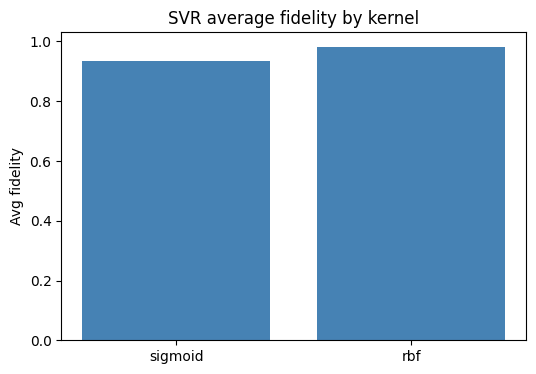

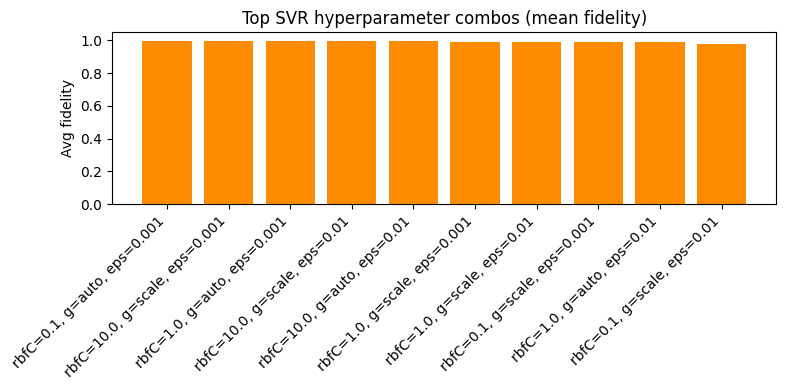

In [48]:
# Fidelity by kernel
fig, ax = plt.subplots(figsize=(6,4))
kernel_stats = results_df.groupby("svr_kernel")["svr_avg_fidelity"].mean().sort_values()
ax.bar(kernel_stats.index, kernel_stats.values, color="steelblue")
ax.set_ylabel("Avg fidelity")
ax.set_title("SVR average fidelity by kernel")
plt.show()

# Fidelity by (kernel, C, gamma, epsilon) combo (top 10)
combo = results_df.groupby(["svr_kernel", "svr_C", "svr_gamma", "svr_epsilon"])["svr_avg_fidelity"].mean()
combo = combo.sort_values(ascending=False).head(10)
combo_df = combo.reset_index()
fig, ax = plt.subplots(figsize=(8,4))
labels = [f"{k}C={c}, g={g}, eps={e}" for k,c,g,e in zip(combo_df.svr_kernel, combo_df.svr_C, combo_df.svr_gamma, combo_df.svr_epsilon)]
ax.bar(range(len(combo_df)), combo_df.svr_avg_fidelity, color="darkorange")
ax.set_xticks(range(len(combo_df)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Avg fidelity")
ax.set_title("Top SVR hyperparameter combos (mean fidelity)")
plt.tight_layout()
plt.show()


### Best SVR vs MLE comparison
Pick the best SVR configuration by fidelity, re-run it to collect predictions, and compare to MLE (metrics + runtime).


In [49]:
# Identify best SVR config by fidelity
best_row = results_df.sort_values(by="svr_avg_fidelity", ascending=False).iloc[0]
best_cfg = {
    "n_states": int(best_row.n_states),
    "n_shots": int(best_row.n_shots),
    "decoherence": float(best_row.decoherence),
}
print("Best SVR config:", best_cfg)
print("Best params:", best_row.svr_best_params)

best_result, best_svr_eval, best_mle_eval = run_experiment(**best_cfg, verbose=False)

print("SVR -> fidelity={:.4f}, mse={:.4f}, train={:.2f}s, infer={:.2f}s".format(
    best_result["svr_avg_fidelity"], best_result["svr_mse"], best_result["svr_train_time"], best_result["svr_infer_time"]
))
print("MLE -> fidelity={:.4f}, mse={:.4f}, time={:.2f}s".format(
    best_result["mle_avg_fidelity"], best_result["mle_mse"], best_result["mle_time"]
))


Best SVR config: {'n_states': 5000, 'n_shots': 5000, 'decoherence': 0.0}
Best params: {'multioutputregressor__estimator__C': 10, 'multioutputregressor__estimator__epsilon': 0.001, 'multioutputregressor__estimator__gamma': 'scale', 'multioutputregressor__estimator__kernel': 'rbf'}
--- SVR ---
MSE (Bloch Vector): 0.000109
Average Fidelity:   0.999650 (+/- 0.000529)
--- MLE ---
MSE (Bloch Vector): 0.051826
Average Fidelity:   0.921448 (+/- 0.125982)
SVR -> fidelity=0.9996, mse=0.0001, train=48.01s, infer=0.67s
MLE -> fidelity=0.9214, mse=0.0518, time=45.60s


### Bloch vector snapshot
Visualize one test state with its ground truth, SVR prediction, and MLE reconstruction.


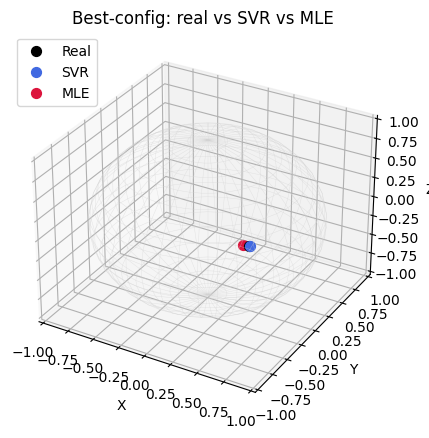

In [50]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_bloch_vectors(real_vec, svr_vec, mle_vec, title="Bloch vectors"):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    # Sphere wireframe
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="lightgray", linewidth=0.3, alpha=0.6)

    ax.scatter(*real_vec, color="black", s=50, label="Real")
    ax.scatter(*svr_vec, color="royalblue", s=50, label="SVR")
    ax.scatter(*mle_vec, color="crimson", s=50, label="MLE")
    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()

# Pick the first test example from the best config run
real_vec = best_svr_eval[["X_real", "Y_real", "Z_real"]].iloc[0].values
svr_vec = best_svr_eval[["X_pred", "Y_pred", "Z_pred"]].iloc[0].values
mle_vec = best_mle_eval[["X_pred", "Y_pred", "Z_pred"]].iloc[0].values
plot_bloch_vectors(real_vec, svr_vec, mle_vec, title="Best-config: real vs SVR vs MLE")


## Per-dataset-size dashboards
Visual summaries (kernels, hyperparameters, shot impact, and Bloch snapshot) for each dataset size.


In [51]:
# Helper plotting functions
from matplotlib import cm


def plot_kernel_bars(df, title="SVR average fidelity by kernel"):
    kernel_stats = df.groupby("svr_kernel")["svr_avg_fidelity"].mean().sort_values()
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(kernel_stats.index, kernel_stats.values, color="steelblue")
    ax.set_ylabel("Avg fidelity")
    ax.set_title(title)
    plt.show()


def plot_top_combos(df, top_k=8, title="Top SVR hyperparameter combos"):
    combo = df.groupby(["svr_kernel", "svr_C", "svr_gamma", "svr_epsilon"])["svr_avg_fidelity"].mean()
    combo = combo.sort_values(ascending=False).head(top_k).reset_index()
    labels = [f"{k}C={c}, g={g}, eps={e}" for k, c, g, e in zip(combo.svr_kernel, combo.svr_C, combo.svr_gamma, combo.svr_epsilon)]
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(range(len(combo)), combo.svr_avg_fidelity, color="darkorange")
    ax.set_xticks(range(len(combo)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Avg fidelity")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_shot_impact(df_size, title_prefix=""):
    # Best SVR fidelity per n_shots (across decoherence/hparams)
    best_svr_by_shot = df_size.sort_values("svr_avg_fidelity").groupby("n_shots").tail(1)
    best_mle_by_shot = df_size.sort_values("mle_avg_fidelity").groupby("n_shots").tail(1)

    shots = sorted(df_size["n_shots"].unique())
    svr_fids = [best_svr_by_shot.loc[best_svr_by_shot.n_shots == s, "svr_avg_fidelity"].values[0] for s in shots]
    mle_fids = [best_mle_by_shot.loc[best_mle_by_shot.n_shots == s, "mle_avg_fidelity"].values[0] for s in shots]

    svr_train = [best_svr_by_shot.loc[best_svr_by_shot.n_shots == s, "svr_train_time"].values[0] for s in shots]
    svr_infer = [best_svr_by_shot.loc[best_svr_by_shot.n_shots == s, "svr_infer_time"].values[0] for s in shots]
    mle_time = [best_mle_by_shot.loc[best_mle_by_shot.n_shots == s, "mle_time"].values[0] for s in shots]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].plot(shots, svr_fids, marker='o', label='SVR (best per shots)', color='royalblue')
    axes[0].plot(shots, mle_fids, marker='s', label='MLE (best per shots)', color='crimson')
    axes[0].set_xscale('log')
    axes[0].set_xlabel('n_shots')
    axes[0].set_ylabel('Avg fidelity')
    axes[0].set_title(f"{title_prefix} Fidelity vs n_shots")
    axes[0].legend()

    axes[1].plot(shots, svr_train, marker='o', label='SVR train', color='royalblue')
    axes[1].plot(shots, svr_infer, marker='^', label='SVR infer', color='dodgerblue')
    axes[1].plot(shots, mle_time, marker='s', label='MLE', color='crimson')
    axes[1].set_xscale('log')
    axes[1].set_xlabel('n_shots')
    axes[1].set_ylabel('Time (s)')
    axes[1].set_title(f"{title_prefix} Runtime vs n_shots")
    axes[1].legend()
    plt.tight_layout()
    plt.show()


def plot_bloch_vectors(real_vec, svr_vec, mle_vec, title="Bloch vectors"):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="lightgray", linewidth=0.3, alpha=0.6)
    ax.scatter(*real_vec, color="black", s=50, label="Real")
    ax.scatter(*svr_vec, color="royalblue", s=50, label="SVR")
    ax.scatter(*mle_vec, color="crimson", s=50, label="MLE")
    ax.set_xlim([-1, 1]); ax.set_ylim([-1, 1]); ax.set_zlim([-1, 1])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()


### Dashboard for n_states = 100


n_rows: {len(df_size)} | shots explored: {sorted(df_size.n_shots.unique())} | decoherence: {sorted(df_size.decoherence.unique())}


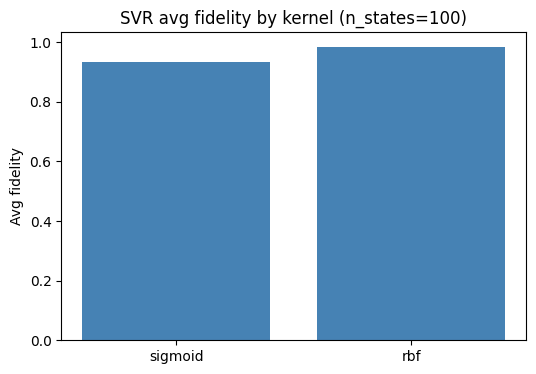

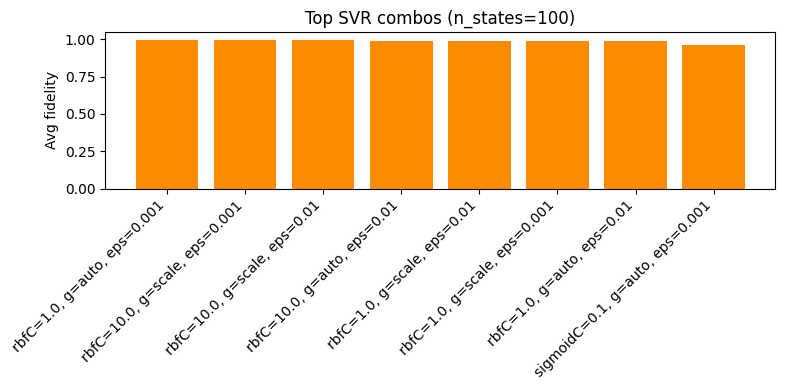

TypeError: unhashable type: 'dict'

In [52]:
df_size = results_df[results_df.n_states == 100]
if df_size.empty:
    raise ValueError("No results for n_states=100. Run the sweeps first.")

print(f"n_rows: {{len(df_size)}} | shots explored: {{sorted(df_size.n_shots.unique())}} | decoherence: {{sorted(df_size.decoherence.unique())}}")

plot_kernel_bars(df_size, title=f"SVR avg fidelity by kernel (n_states=100)")
plot_top_combos(df_size, title=f"Top SVR combos (n_states=100)")

best_row_size = df_size.sort_values(by="svr_avg_fidelity", ascending=False).iloc[0]
best_cfg_size = {{
    "n_states": int(best_row_size.n_states),
    "n_shots": int(best_row_size.n_shots),
    "decoherence": float(best_row_size.decoherence),
}}
print("Best SVR params:", best_row_size.svr_best_params)
print("Best config:", best_cfg_size)

best_res_size, best_svr_eval_size, best_mle_eval_size = run_experiment(**best_cfg_size, verbose=False)
print("SVR -> fidelity={{{:.4f}}}, mse={{{:.4f}}}, train={{{:.2f}}}s, infer={{{:.2f}}}s".format(
    best_res_size["svr_avg_fidelity"], best_res_size["svr_mse"], best_res_size["svr_train_time"], best_res_size["svr_infer_time"]
))
print("MLE -> fidelity={{{:.4f}}}, mse={{{:.4f}}}, time={{{:.2f}}}s".format(
    best_res_size["mle_avg_fidelity"], best_res_size["mle_mse"], best_res_size["mle_time"]
))

plot_shot_impact(df_size, title_prefix=f"n_states=100")

real_vec = best_svr_eval_size[["X_real", "Y_real", "Z_real"]].iloc[0].values
svr_vec = best_svr_eval_size[["X_pred", "Y_pred", "Z_pred"]].iloc[0].values
mle_vec = best_mle_eval_size[["X_pred", "Y_pred", "Z_pred"]].iloc[0].values
plot_bloch_vectors(real_vec, svr_vec, mle_vec, title=f"Bloch vectors (n_states=100)")


### Dashboard for n_states = 1000


In [ ]:
df_size = results_df[results_df.n_states == 1000]
if df_size.empty:
    raise ValueError("No results for n_states=1000. Run the sweeps first.")

print(f"n_rows: {{len(df_size)}} | shots explored: {{sorted(df_size.n_shots.unique())}} | decoherence: {{sorted(df_size.decoherence.unique())}}")

plot_kernel_bars(df_size, title=f"SVR avg fidelity by kernel (n_states=1000)")
plot_top_combos(df_size, title=f"Top SVR combos (n_states=1000)")

best_row_size = df_size.sort_values(by="svr_avg_fidelity", ascending=False).iloc[0]
best_cfg_size = {{
    "n_states": int(best_row_size.n_states),
    "n_shots": int(best_row_size.n_shots),
    "decoherence": float(best_row_size.decoherence),
}}
print("Best SVR params:", best_row_size.svr_best_params)
print("Best config:", best_cfg_size)

best_res_size, best_svr_eval_size, best_mle_eval_size = run_experiment(**best_cfg_size, verbose=False)
print("SVR -> fidelity={{{:.4f}}}, mse={{{:.4f}}}, train={{{:.2f}}}s, infer={{{:.2f}}}s".format(
    best_res_size["svr_avg_fidelity"], best_res_size["svr_mse"], best_res_size["svr_train_time"], best_res_size["svr_infer_time"]
))
print("MLE -> fidelity={{{:.4f}}}, mse={{{:.4f}}}, time={{{:.2f}}}s".format(
    best_res_size["mle_avg_fidelity"], best_res_size["mle_mse"], best_res_size["mle_time"]
))

plot_shot_impact(df_size, title_prefix=f"n_states=1000")

real_vec = best_svr_eval_size[["X_real", "Y_real", "Z_real"]].iloc[0].values
svr_vec = best_svr_eval_size[["X_pred", "Y_pred", "Z_pred"]].iloc[0].values
mle_vec = best_mle_eval_size[["X_pred", "Y_pred", "Z_pred"]].iloc[0].values
plot_bloch_vectors(real_vec, svr_vec, mle_vec, title=f"Bloch vectors (n_states=1000)")


### Dashboard for n_states = 5000


In [ ]:
df_size = results_df[results_df.n_states == 5000]
if df_size.empty:
    raise ValueError("No results for n_states=5000. Run the sweeps first.")

print(f"n_rows: {{len(df_size)}} | shots explored: {{sorted(df_size.n_shots.unique())}} | decoherence: {{sorted(df_size.decoherence.unique())}}")

plot_kernel_bars(df_size, title=f"SVR avg fidelity by kernel (n_states=5000)")
plot_top_combos(df_size, title=f"Top SVR combos (n_states=5000)")

best_row_size = df_size.sort_values(by="svr_avg_fidelity", ascending=False).iloc[0]
best_cfg_size = {{
    "n_states": int(best_row_size.n_states),
    "n_shots": int(best_row_size.n_shots),
    "decoherence": float(best_row_size.decoherence),
}}
print("Best SVR params:", best_row_size.svr_best_params)
print("Best config:", best_cfg_size)

best_res_size, best_svr_eval_size, best_mle_eval_size = run_experiment(**best_cfg_size, verbose=False)
print("SVR -> fidelity={{{:.4f}}}, mse={{{:.4f}}}, train={{{:.2f}}}s, infer={{{:.2f}}}s".format(
    best_res_size["svr_avg_fidelity"], best_res_size["svr_mse"], best_res_size["svr_train_time"], best_res_size["svr_infer_time"]
))
print("MLE -> fidelity={{{:.4f}}}, mse={{{:.4f}}}, time={{{:.2f}}}s".format(
    best_res_size["mle_avg_fidelity"], best_res_size["mle_mse"], best_res_size["mle_time"]
))

plot_shot_impact(df_size, title_prefix=f"n_states=5000")

real_vec = best_svr_eval_size[["X_real", "Y_real", "Z_real"]].iloc[0].values
svr_vec = best_svr_eval_size[["X_pred", "Y_pred", "Z_pred"]].iloc[0].values
mle_vec = best_mle_eval_size[["X_pred", "Y_pred", "Z_pred"]].iloc[0].values
plot_bloch_vectors(real_vec, svr_vec, mle_vec, title=f"Bloch vectors (n_states=5000)")
